![uc3m](img/uc3m.jpg)

# Solving Nonlinear Models

<a href="http://www.est.uc3m.es/nogales" target="_blank">Javier Nogales</a>

# 1.  Unconstrained case

## A famous example: the Rosenbrock's function

It is a 2D non-convex function, also known as Rosenbrock's valley or Rosenbrock's banana function.

<img src="img/Rosenbrock.png" width="500">

The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To find the global minimum, however, is difficult.

<img src="img/Rosenbrock2.png" width="500">

It has a global minimum at $(x,y)=(1,1)$



### Python definition of objective and gradient

In [1]:
def rosenbrock(x):   # The rosenbrock function
    return (1 - x[0])**2 + 100.0*(x[1] - x[0]**2)**2
# Calculate the gradient function
def gradient(x):
    return np.array((-2*(1 - x[0]) - 4*100*x[0]*(x[1] - x[0]**2), 2*100*(x[1] - x[0]**2)))

### The Rosenbrock's valley

The valley is easy to find, but not the minimizer inside the valley (hidden for simple algorithms)

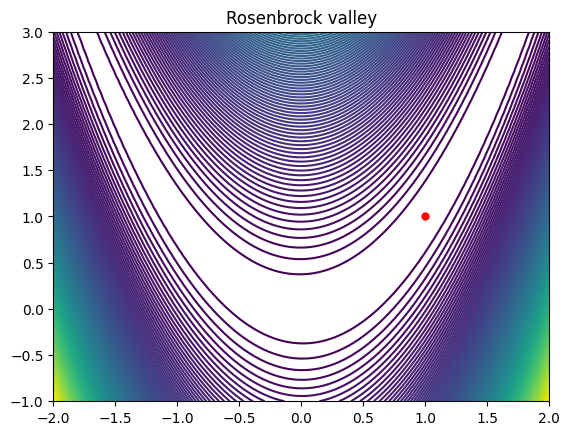

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x, y = np.mgrid[-2:2:100j, -1:3:100j]
z = rosenbrock([x, y])

plt.contour(x,y,z,200)
plt.plot(1, 1, marker='o',markersize=5, color ='r')
plt.title('Rosenbrock valley')
plt.show()
# Minimizer is in red point (1,1)

## Solution with Scipy

### Derivative-free optimization

Sometimes the functions are non-smooth or noisy or expensive to compute. In those cases, approximating the derivatives is not a good idea. Better to use  derivative-free optimization (do not use derivatives or finite differences)

The drawback is the number of iterations they need to reach the solution

In our example, even if it is smooth, we can apply these ideas

- In Scipy, Nelder-Mead and Powell methods are used to optimize with no derivatives

In [3]:
from scipy.optimize import minimize

# Mandatory to select initial point
x0 = np.array([-1.2,1.0]) # difficult initial point

# Gradient-free method: 'Nelder-Mead' 
res = minimize(rosenbrock, x0, method='Nelder-Mead', options={'disp': True}) # Call function
print(res.x,"\n")

# Gradient-free method: 'Powell'
res = minimize(rosenbrock, x0, method='Powell', options={'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 85
         Function evaluations: 159
[1.00002202 1.00004222] 

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 665
[1. 1.]


Powell's method finds the minimum in less iterations, but with more function evaluations than Nelder-Mead method.

### Gradient information: quasi-Newton

Of course, when the function is smooth, it is better to consider the information from derivatives

In [4]:
# quasi-Newton method
# Implemented last time too
# Remember BFGS -> Developer names

# We only use first derivatives
res = minimize(rosenbrock, x0, method='BFGS', jac=gradient, options={'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 39
         Gradient evaluations: 39
[0.99999997 0.99999995]


Less iterations, less function evaluations

## Solution with Pyomo

Pyomo provides first and second derivative information using the automatic differentiation features in the Ampl Solver Library (ASL), hence gradient information is provided automatically


### Install a very good non-linear solver: IPOPT

    conda install -c conda-forge ipopt

IPOPT is an open source software package for large-scale nonlinear optimization

In [5]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

model = ConcreteModel() 
model.x = Var(initialize=2) # easy initial point
model.y = Var(initialize=2) # easy initial point

def rosenbrock(m):
    return (1.0-m.x)**2 + 100.0*(m.y - m.x**2)**2
model.obj = Objective(rule=rosenbrock, sense=minimize)


In [7]:
#solver = SolverFactory('ipopt')
#solver.solve(model)

# If you have problems with ipopt locally, try the NEOS Server
opt = SolverFactory('ipopt')  # Select solver
solver_manager = SolverManagerFactory('neos')  # Solve in neos server
solver_manager.solve(model, opt=opt)


RuntimeError: NEOS requires a valid email address. Please set the 'NEOS_EMAIL' environment variable.

In [7]:
# Display solution

print()
print('*** Solution *** :') 
print('x:', value(model.x)) 
print('y:', value(model.y))


*** Solution *** :
x: 1.0000000000000109
y: 1.0000000000000215


In [8]:
model = ConcreteModel() 
model.x = Var(initialize=-1.2) # difficult initial point
model.y = Var(initialize=2) # difficult initial point

def rosenbrock(m):
    return (1.0-m.x)**2 + 100.0*(m.y - m.x**2)**2
model.obj = Objective(rule=rosenbrock, sense=minimize)

solver.solve(model)

print()
print('*** Solution *** :') 
print('x:', value(model.x)) 
print('y:', value(model.y))


*** Solution *** :
x: 0.9999999999999137
y: 0.9999999999998253


IPOPT is one of the best non-linear solvers

### Finally, solve the Rosenbrock's problem for different initial values 

For non-convex problems, try to solve them from different starting points

In [9]:
from pyomo.environ import *

model = ConcreteModel()
model.x = Var()
model.y = Var()

def rosenbrock(m):
    return (1.0-m.x)**2 + 100.0*(m.y - m.x**2)**2
model.obj = Objective(rule=rosenbrock, sense=minimize)
 
print('x0,      y0,     xsol, ysol,  time')

for x_init in range(-2, 3):
    for y_init in range(-2, 3):
        model.x = x_init
        model.y = y_init   

        solver = SolverFactory('ipopt')
        results = solver.solve(model)

        print("{0:6.2f} {1:6.2f} {2:6.2f} {3:6.2f} {4:4.3f}".format(x_init, y_init, value(model.x), value(model.y), results.Solver.Time))


x0,      y0,     xsol, ysol,  time
 -2.00  -2.00   1.00   1.00 0.333
 -2.00  -1.00   1.00   1.00 0.315
 -2.00   0.00   1.00   1.00 0.328
 -2.00   1.00   1.00   1.00 0.322
 -2.00   2.00   1.00   1.00 0.319
 -1.00  -2.00   1.00   1.00 0.315
 -1.00  -1.00   1.00   1.00 0.319
 -1.00   0.00   1.00   1.00 0.321
 -1.00   1.00   1.00   1.00 0.316
 -1.00   2.00   1.00   1.00 0.319
  0.00  -2.00   1.00   1.00 0.313
  0.00  -1.00   1.00   1.00 0.321
  0.00   0.00   1.00   1.00 0.326
  0.00   1.00   1.00   1.00 0.321
  0.00   2.00   1.00   1.00 0.325
  1.00  -2.00   1.00   1.00 0.312
  1.00  -1.00   1.00   1.00 0.305
  1.00   0.00   1.00   1.00 0.302
  1.00   1.00   1.00   1.00 0.027
  1.00   2.00   1.00   1.00 0.312
  2.00  -2.00   1.00   1.00 0.318
  2.00  -1.00   1.00   1.00 0.315
  2.00   0.00   1.00   1.00 0.313
  2.00   1.00   1.00   1.00 0.315
  2.00   2.00   1.00   1.00 0.311


The more computational time, the more difficult initial point

# 2. The constrained case

### Example

Find the point on a plane $2x - y + z = 3$ that is closest to the origin 

We seek to minimize $x^2 + y^2 + z^2$ subject to the equality constraint defined by the plane

## Solution with SciPy

With constraints, only 'SLSQP' and 'trust-constr' are available methods

In [10]:
import numpy as np
from scipy.optimize import minimize

def objective(X):
    x, y, z = X
    return x**2 + y**2 + z**2

def gradient(X):
    x, y, z = X
    return np.array([2*x,2*y,2*z])

def eq_cons(X):
    x, y, z = X
    return 2 * x - y + z - 3

sol = minimize(objective, x0=[0, 0, 0], constraints={'type': 'eq', 'fun': eq_cons}, jac=gradient, 
               method='SLSQP', options={'disp': True})
sol

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4999999967403708
            Iterations: 3
            Function evaluations: 4
            Gradient evaluations: 3


     fun: 1.4999999967403708
     jac: array([ 2.00000001, -0.99999999,  0.99999999])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 1.        , -0.5       ,  0.49999999])

Note the solution is in the plane $2𝑥−𝑦+𝑧=3$

## Get the Lagrange multipliers

We need to use the 'trust-constr' method to get the Lagrange multipliers

In [11]:
sol = minimize(objective, x0=[0, 0, 0], constraints={'type': 'eq', 'fun': eq_cons}, jac=gradient, 
               method='trust-constr', options={'disp': True}) # Call trust-constr -> More related with newton -> Better to get lambda
print("x=",sol.x,"\n")

# these are the lagrange multipliers
print("lambda=",sol.v) # sol.v == lambda

`gtol` termination condition is satisfied.
Number of iterations: 3, function evaluations: 3, CG iterations: 0, optimality: 4.44e-16, constraint violation: 0.00e+00, execution time:  1.9 s.
x= [ 1.  -0.5  0.5] 

lambda= [array([-1.])]


/Users/javiernogales/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


For equality constraints, Lagrange multipliers can be positive or negative (or even 0)

### Example with inequality constraints and jacobian matrix for constraints, $\nabla c(x)$

The objective is $\max\ 2x_1 x_2 + 2x_1 - x_1^2 - 2x_2^2$

subject to: $x_1^3 - x_2 = 0$

and $x_2 \geq 1$


In [12]:
# If objective and constraints are nonlinear, then u need to add the gradient constraint which is the derivative of the objective
def func(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

def func_deriv(x):
    return np.array([ -(-2*x[0] + 2*x[1] + 2), -(2*x[0] - 4*x[1]) ])

# Add constraint
cons = ({'type': 'eq',
    'fun' : lambda x: np.array([x[0]**3 - x[1]]),
    'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
    {'type': 'ineq',
    'fun' : lambda x: np.array([x[1] - 1]),
    'jac' : lambda x: np.array([0.0, 1.0])})

# Call minimize function
res = minimize(func, x0=[-1.0,1.0], jac=func_deriv, 
               constraints=cons, method='SLSQP', options={'disp': True})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0000001831052137
            Iterations: 9
            Function evaluations: 14
            Gradient evaluations: 9
[1.00000009 1.        ]


## Get the Lagrange multipliers

In [13]:
res = minimize(func, x0=[-1.0,1.0], jac=func_deriv, 
               constraints=cons, method='trust-constr', options={'disp': True})

print("\nx=",res.x,"\n")

# these are the lagrange multipliers
print("lambda=",res.v)

`gtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 14, CG iterations: 13, optimality: 8.73e-13, constraint violation: 3.12e-09, execution time: 0.038 s.

x= [1.00000801 1.00002403] 

lambda= [array([0.66666666]), array([-1.33341342])]


Take care: the Lagrange multiplier corresponding to $x_2 \geq 1$ is negative, and in the slides it should be positive

Reason: in method='trust-constr', the lagrangian function is defined as $f(x)+\lambda c(x)$ instead of  $f(x)-\lambda c(x)$ (as in the slides)

# Optimality conditions

## First-order conditions 

$\min x + y$

subject to: $x^2 + y^2=1$

and $x,y\geq 0$

In [14]:
def objective(x):
    return x[0]+x[1]
 
def eq_cons(x):
    return x[0]**2 + x[1]**2-1

bnds = ((0, None), (0, None))

solution = minimize(objective,x0=[0,0],method='trust-constr', bounds=bnds,constraints={'type': 'eq', 'fun': eq_cons}, options={'disp': True})

print(solution.x)
print(solution.fun)

# lagrange multipliers
print(solution.v)

# Very fast with 0.026s
# 0.7 , 0.7 -> Maximum
# But we are minimizing??? 
# Do not use this solution because we are minimizing

`gtol` termination condition is satisfied.
Number of iterations: 11, function evaluations: 18, CG iterations: 4, optimality: 1.57e-16, constraint violation: 4.92e-09, execution time: 0.026 s.
[0.70710678 0.70710678]
1.4142135658511819
[array([-0.70707477]), array([-4.52548339e-05, -4.52548339e-05])]


Check the solution candidate satisfies the first-order conditions, but scipy is getting a maximizer, not a minimizer 😱

### The same with Pyomo

In [15]:
from pyomo.environ import *  

M = ConcreteModel()  

M.x1 = Var(within = NonNegativeReals, initialize=0.0)  # create x1
M.x2 = Var(within = NonNegativeReals, initialize=0.0)  # create x2  Try 0.2

# define objective
M.obj = Objective(
    expr=M.x1 + M.x2,
    sense=minimize)

# constraints
M.cons = Constraint(
    expr = M.x1**2+M.x2**2 == 1)

# obtain the solution 
solver = SolverFactory("ipopt") # define the solver
M.dual = Suffix(direction=Suffix.IMPORT)
solution = solver.solve(M) # solve

# Display solution
print('x1=',M.x1())
print('x2=',M.x2())

# Display lagrange multipliers
display(M.dual)

# Solve by hand and get all the possible solutions
# Make sure you have the optimal one

x1= 0.7071067811865449
x2= 0.7071067811865501
dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key  : Value
    cons : 0.7071067786806617


Again, ipopt is getting a maximizer, not a minimizer 😱 

How can we get minimizers?

# Second-order necessary conditions

Example: $\min f(x)=x_1^2 - 2x_1 + x_2^2 - x_3^2 + 4 x_3$

subject to: $x_1 - x_2 + 2x_3 = 2$

In [16]:
from pyomo.environ import *  

M = ConcreteModel()  

M.x1 = Var()  # create x1
M.x2 = Var()  # create x2 
M.x3 = Var()  # create x2 

# define objective
M.obj = Objective(expr=M.x1**2-2*M.x1+M.x2**2-M.x3**2+4*M.x3, sense=minimize)

# constraints
M.cons = Constraint(expr = M.x1-M.x2+2*M.x3 == 2)

# obtain the solution 
solver = SolverFactory("ipopt") # define the solver
M.dual = Suffix(direction=Suffix.IMPORT)
solution = solver.solve(M) # solve

# Display solution
print('x1=',M.x1())
print('x2=',M.x2())
print('x3=',M.x3())

# Display lagrange multipliers
display(M.dual)

from scipy.linalg import null_space

J = np.array([[1,-1,2]])
Z = null_space(J)
print("\nOrthonormal basis Z=")
print(Z,"\n")
print("It is indeed a null space:")
print(J.dot(Z),"\n")
print("It is indeed orthonormal, not orthogonal:")
print(Z.T.dot(Z),"\n")

print("Reduced Hessian:")
H = np.array([[2,0,0],
             [0,2,0],
             [0,0,-2]])
print(Z.T.dot(H).dot(Z),"\n")

from numpy import linalg as LA

print("Eigenvalues and eigenvectors of reduced matrix:")
w, v = LA.eig(Z.T.dot(H).dot(Z))
print(w,"\n")
print("They are positive!")

x1= 2.5
x2= -1.5
x3= -1.0
dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key  : Value
    cons :   3.0

Orthonormal basis Z=
[[ 0.40824829 -0.81649658]
 [ 0.88164966  0.23670068]
 [ 0.23670068  0.52659863]] 

It is indeed a null space:
[[ 1.11022302e-16 -4.44089210e-16]] 

It is indeed orthonormal, not orthogonal:
[[ 1.00000000e+00 -5.55111512e-17]
 [-5.55111512e-17  1.00000000e+00]] 

Reduced Hessian:
[[ 1.77589115 -0.49858503]
 [-0.49858503  0.89077552]] 

Eigenvalues and eigenvectors of reduced matrix:
[2.         0.66666667] 

They are positive!


Please note there is one negative eigenvalue in the Lagrangian hessian

# Exit conditions

As with linear models, the exit condition can be:

- Successful Exit
- Successful Exit with regularization at solution 
- Infeasible
- Unbounded

### Example:

The objective is $\min x_2$

subject to: $x_1^2 + x_2 = 1$

and $-1\leq x_1 \leq 1$

<img src="ExitCondition.png" width="500">


In [17]:
from pyomo.environ import *  

M = ConcreteModel()  

M.x1 = Var(bounds=(-1,1), initialize=0.5)  # create x1
M.x2 = Var(initialize=0.5)  # create x2 

# define objective
M.obj = Objective(expr=M.x2, sense=minimize)

# constraints
M.cons = Constraint(expr = M.x1**2+M.x2 == 1)

# obtain the solution 
solver = SolverFactory("ipopt") # define the solver
solution = solver.solve(M, tee=True) # solve

# Display solution
print('\n')
print('x1=',M.x1())
print('x2=',M.x2())
print('\n')
print(solution)


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total

Now a different initial point with a good final status but some problems in the middle: if at some iteration the algorithm finds an indicator of poor conditioning, then it adds a penalty (regularization)

In [18]:
M = ConcreteModel()  

M.x1 = Var(bounds=(-1,1), initialize=0.0)  # create x1
M.x2 = Var(initialize=2.0)  # create x2 

# define objective
M.obj = Objective(expr=M.x2, sense=minimize)

# constraints
M.cons = Constraint(expr = M.x1**2+M.x2 == 1)

# obtain the solution 
solver = SolverFactory("ipopt") # define the solver
solution = solver.solve(M, tee=True) # solve

# Display solution
print('\n')
print('x1=',M.x1())
print('x2=',M.x2())
print('\n')
print(solution)

# solution (0,1) -> maximizer
# Gradient = 0 -> (1,0) and (0,1) is the same for the algorithm

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total

Status is ok, but the solution is indeed a maximizer...

Let's see what happens if we add this constraint: $x_2\geq 2$

In [19]:
M = ConcreteModel()  

M.x1 = Var(bounds=(-1,1), initialize=0.0)  # create x1
M.x2 = Var(initialize=2.0)  # create x2 

# define objective
M.obj = Objective(expr=M.x2, sense=minimize)

# constraints
M.cons1 = Constraint(expr = M.x1**2+M.x2 == 1)
M.cons2 = Constraint(expr = M.x2 >= 2)

# obtain the solution 
solver = SolverFactory("ipopt") # define the solver
solution = solver.solve(M, tee=True) # solve

# Display solution
print('\n')
print('x1=',M.x1())
print('x2=',M.x2())
print('\n')
print(solution)

# Alg thinks the problem is infeasable
# 

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total

Finally, let's remove this bound: $x_1 \leq 1$

In [20]:
M = ConcreteModel()  

M.x1 = Var(initialize=0.0)  # create x1
M.x2 = Var(initialize=2.0)  # create x2 

# define objective
M.obj = Objective(expr=M.x2, sense=minimize)

# constraints
M.cons1 = Constraint(expr = M.x1**2+M.x2 == 1)
M.cons2 = Constraint(expr = M.x1 >= -1) # 

# obtain the solution 
solver = SolverFactory("ipopt") # define the solver
solution = solver.solve(M, tee=True) # solve

# Display solution
print('\n')
print('x1=',M.x1())
print('x2=',M.x2())
print('\n')
print(solution)

# Forgot to add important constraint

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total

# Final considerations 

- IPOPT is a barrier method: it relaxes the constraint $x\geq 0$ into a barrier term in the objective function $-\mu \sum_i \log(x_i)$, and makes the barrier parameter smaller at each iteration, using an interior-point framework

  We can set the initial value of the barrier parameter:

        solver.options['mu_init'] = 1e-4
    
    
- The initial point is crucial for effective solution. Try some of them to avoid maximizers and saddle points

- Many mathematical functions have a valid domain, and evaluation outside that domain causes errors

     Example: $1/\sqrt{x}$. We should add the constraint $x\geq 0.01$